<a href="https://colab.research.google.com/github/PChan8128/Pchan8128.github.io/blob/main/DEFCON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, \
    ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import mean_absolute_error,confusion_matrix,accuracy_score
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [ ]:
from zipfile import ZipFile
file_name = 'defcon.zip'

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print("done")

done


In [ ]:
train = pd.read_csv('/content/Dataset/train.csv')
train.head()


,Allied_Nations,Diplomatic_Meetings_Set,Percent_Of_Forces_Mobilized,Hostile_Nations,Active_Threats,Inactive_Threats,Citizen_Fear_Index,Closest_Threat_Distance(km),Aircraft_Carriers_Responding,Troops_Mobilized(thousands),DEFCON_Level,ID
0,16,1,0.67,3,6.0,25.0,0.787812,324.36,1,862400.0,3,7570
1,8,1,0.11,2,38.0,48.0,0.419236,359.34,0,959200.0,4,12128
2,9,1,0.49,3,32.0,69.0,0.582232,332.84,1,836000.0,3,2181
3,7,0,0.30,2,31.0,52.0,0.589574,358.28,1,924000.0,3,5946
4,8,1,0.12,5,13.0,42.0,0.552863,364.64,0,968000.0,2,9054


In [ ]:
train.shape

(10000, 12)

In [ ]:
test = pd.read_csv('/content/Dataset/test.csv')
test.head()

,Allied_Nations,Diplomatic_Meetings_Set,Percent_Of_Forces_Mobilized,Hostile_Nations,Active_Threats,Inactive_Threats,Citizen_Fear_Index,Closest_Threat_Distance(km),Aircraft_Carriers_Responding,Troops_Mobilized(thousands),ID
0,8,0,0.52,2,19.0,52.0,0.376652,319.06,1,976800.0,1
1,9,0,0.44,2,6.0,12.0,0.254772,351.92,1,1082400.0,10
2,8,0,0.44,3,7.0,18.0,0.472100,349.80,1,924000.0,14
3,10,0,0.39,2,3.0,13.0,0.478708,343.44,1,1003200.0,17
4,9,0,0.44,2,6.0,14.0,0.561674,346.62,1,924000.0,21


In [ ]:
test.shape

(2500, 11)

In [ ]:
sample_submission = pd.read_csv('/content/Dataset/sample_submission.csv')
sample_submission.head()

,ID,DEFCON_Level
0,1,0
1,10,1
2,14,2
3,17,3
4,21,0


In [ ]:
print(train.DEFCON_Level.value_counts())

2    4270
3    3910
4    1212
1     498
5     110
Name: DEFCON_Level, dtype: int64


In [ ]:
train.describe()

,Allied_Nations,Diplomatic_Meetings_Set,Percent_Of_Forces_Mobilized,Hostile_Nations,Active_Threats,Inactive_Threats,Citizen_Fear_Index,Closest_Threat_Distance(km),Aircraft_Carriers_Responding,Troops_Mobilized(thousands),DEFCON_Level,ID
count,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000
mean,8.317800,0.524100,0.270548,2.50230,15.754300,46.534600,0.486639,350.885758,0.891300,9.174874e+05,2.616600,6266.554200
std,1.748802,0.500244,0.196434,1.31178,10.388906,34.012649,0.134552,16.285744,0.329082,9.271764e+04,0.802788,3610.170288
min,5.000000,0.000000,0.000000,1.00000,1.000000,6.000000,0.000000,290.440000,0.000000,7.392000e+05,1.000000,2.000000
25%,7.000000,0.000000,0.090000,2.00000,7.000000,21.000000,0.406021,340.260000,1.000000,8.360000e+05,2.000000,3139.750000
50%,8.000000,1.000000,0.260000,2.00000,13.000000,37.000000,0.486784,350.860000,1.000000,8.976000e+05,3.000000,6280.500000
75%,9.000000,1.000000,0.430000,3.00000,21.000000,62.000000,0.567548,360.400000,1.000000,9.768000e+05,3.000000,9391.500000
max,16.000000,2.000000,1.000000,16.00000,72.000000,289.000000,1.000000,425.060000,2.000000,1.311200e+06,5.000000,12500.000000


In [ ]:
train = train.fillna(' ')
nan_rows = train[train.isnull().any(1)]

In [ ]:
#Concat train and test. Drop "ID" column and split train data
data = pd.concat([train, test], axis=0)   #concat train and test

data = data.drop(columns = ['ID'])
# Retrieve data from the train set
X = data[:10000].drop(columns=['DEFCON_Level'])
# Retrieve label from train set
y = data[:10000].DEFCON_Level
# Retrieve data from test set
X_test = data[10000:].drop(columns=['DEFCON_Level'])
# split train file into train set (0.75) and valid set (0.25). The valid set is used to evaluate the model on the train set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
print("Number of data points in train data:",X_train.shape)
print("Number of data points in test data:",X_valid.shape)

Number of data points in train data: (7500, 10)
Number of data points in test data: (2500, 10)


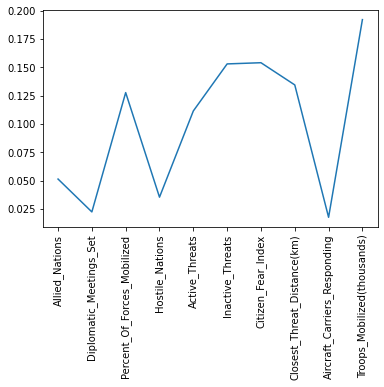

In [ ]:
def feature_importances():
    for c in data.columns[data.dtypes == 'object']:
        X_train[c] = X_train[c].factorize()[0]
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    plt.plot(rf.feature_importances_)
    plt.xticks(np.arange(X_train.shape[1]), X_train.columns.tolist(), rotation=90)
    plt.show()

feature_importances()

In [ ]:
corr = X.corr()
corr.style.background_gradient(cmap='coolwarm')

,Allied_Nations,Diplomatic_Meetings_Set,Percent_Of_Forces_Mobilized,Hostile_Nations,Active_Threats,Inactive_Threats,Citizen_Fear_Index,Closest_Threat_Distance(km),Aircraft_Carriers_Responding,Troops_Mobilized(thousands)
Allied_Nations,1.000000,-0.278779,0.650308,0.111896,-0.113609,-0.067496,0.647604,-0.668521,0.096352,-0.110071
Diplomatic_Meetings_Set,-0.278779,1.000000,-0.576116,-0.036662,0.019046,0.089007,-0.030756,0.241155,-0.106499,-0.201561
Percent_Of_Forces_Mobilized,0.650308,-0.576116,1.000000,0.149317,-0.036675,0.054474,0.357324,-0.529314,0.166989,0.085870
Hostile_Nations,0.111896,-0.036662,0.149317,1.000000,0.146773,0.220252,0.299244,-0.081724,-0.004865,0.025103
Active_Threats,-0.113609,0.019046,-0.036675,0.146773,1.000000,0.674970,-0.009510,0.034700,-0.023317,-0.084188
Inactive_Threats,-0.067496,0.089007,0.054474,0.220252,0.674970,1.000000,0.103296,-0.084670,-0.004199,-0.227941
Citizen_Fear_Index,0.647604,-0.030756,0.357324,0.299244,-0.009510,0.103296,1.000000,-0.336929,0.085540,-0.495305
Closest_Threat_Distance(km),-0.668521,0.241155,-0.529314,-0.081724,0.034700,-0.084670,-0.336929,1.000000,-0.008636,0.177008
Aircraft_Carriers_Responding,0.096352,-0.106499,0.166989,-0.004865,-0.023317,-0.004199,0.085540,-0.008636,1.000000,0.073819
Troops_Mobilized(thousands),-0.110071,-0.201561,0.085870,0.025103,-0.084188,-0.227941,-0.495305,0.177008,0.073819,1.000000


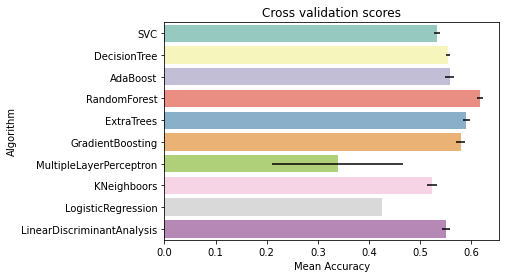

In [ ]:
def compare_tree_based_models():
    random_state = 2
    classifiers = [SVC(random_state=random_state), DecisionTreeClassifier(random_state=random_state),
                   AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), random_state=random_state,
                                      learning_rate=0.1), RandomForestClassifier(random_state=random_state),
                   ExtraTreesClassifier(random_state=random_state),
                   GradientBoostingClassifier(random_state=random_state), MLPClassifier(random_state=random_state),
                   KNeighborsClassifier(), LogisticRegression(random_state=random_state), LinearDiscriminantAnalysis()]

    cv_results = []
    for classifier in classifiers:
        cv_results.append(cross_val_score(classifier, X_train, y=y_train, scoring="accuracy", cv=4, n_jobs=4))

    cv_means = []
    cv_std = []
    for cv_result in cv_results:
        cv_means.append(cv_result.mean())
        cv_std.append(cv_result.std())
    cv_res = pd.DataFrame(
        {"CrossValMeans": cv_means, "CrossValerrors": cv_std, "Algorithm": ["SVC", "DecisionTree", "AdaBoost",
                                                                            "RandomForest", "ExtraTrees",
                                                                            "GradientBoosting",
                                                                            "MultipleLayerPerceptron", "KNeighboors",
                                                                            "LogisticRegression",
                                                                            "LinearDiscriminantAnalysis"]})

    g = sns.barplot("CrossValMeans", "Algorithm", data=cv_res, palette="Set3", orient="h", **{'xerr': cv_std})
    g.set_xlabel("Mean Accuracy")
    g = g.set_title("Cross validation scores")
    plt.show()

compare_tree_based_models()

In [ ]:
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split

In [ ]:
parameter_train = test.columns
X = train[parameter_train]
Y = train['DEFCON_Level']

In [ ]:
#splitting into train and test set
train_X,val_x,train_Y,val_y = train_test_split(X,Y,random_state =1)

In [ ]:
print("Number of data points in train data:",train_X.shape)
print("Number of data points in test data:",val_x.shape)

Number of data points in train data: (7500, 11)
Number of data points in test data: (2500, 11)


In [ ]:
rfc_model = RandomForestClassifier(n_estimators = 500,random_state = 0)
rfc_model.fit(train_X,train_Y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
print(mean_absolute_error(rfc_model.predict(val_x),val_y))
array=confusion_matrix(rfc_model.predict(val_x),val_y)
print(confusion_matrix(rfc_model.predict(val_x),val_y))


0.4108
[[ 15  13   2   1   0]
 [ 75 771 287  22   1]
 [ 25 248 637 161   7]
 [  2  16  74 132  10]
 [  0   1   0   0   0]]


In [ ]:
print("Random Forest model accuracy(in %):", metrics.accuracy_score(val_y,rfc_model.predict(val_x))*100)

Random Forest model accuracy(in %): 62.2


In [ ]:
KNN = KNeighborsClassifier(n_neighbors = 30)
KNN.fit(train_X,train_Y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=30, p=2,
                     weights='uniform')

In [ ]:
print(mean_absolute_error(KNN.predict(val_x),val_y))
print(confusion_matrix(KNN.predict(val_x),val_y))


0.5192
[[  0   0   0   0   0]
 [ 68 737 408  35   5]
 [ 46 299 543 238  11]
 [  3  13  49  43   2]
 [  0   0   0   0   0]]


In [ ]:
print("\n KNN model accuracy(in %):", metrics.accuracy_score(val_y,KNN.predict(val_x))*100)


 KNN model accuracy(in %): 52.92


In [ ]:
DTC = DecisionTreeClassifier(min_samples_split=100,random_state = 0)
DTC.fit(train_X,train_Y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [ ]:
print(mean_absolute_error(DTC.predict(val_x),val_y))
print(confusion_matrix(DTC.predict(val_x),val_y))

0.406
[[ 11  11   1   0   0]
 [ 70 744 244  28   2]
 [ 33 274 678 140   4]
 [  3  20  77 148  12]
 [  0   0   0   0   0]]


In [ ]:
print("\n DecisionTreeClassifier model accuracy(in %):", metrics.accuracy_score(val_y,DTC.predict(val_x))*100)


 DecisionTreeClassifier model accuracy(in %): 63.239999999999995


In [ ]:
preds = np.round(DTC.predict(test))
output = pd.DataFrame({"ID": test.ID,"DEFCON_Level": preds })
output.to_csv("mini-defcon.csv",index = False)